<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/project/mdd_eeg_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://figshare.com/ndownloader/articles/4244171/versions/2

In [ ]:
!unzip 2

In [ ]:
!pip install mne

In [5]:
import os
import mne

mne.set_log_level('ERROR')


raws = []
for file in os.scandir('.'):
  _, ext = os.path.splitext(file.path)
  if ext == ".edf":
    raws.append(mne.io.read_raw_edf(file.path))

In [6]:
#@title Dataset class
import torch
from torch.utils.data import Dataset

# at first let's ignore timestamps, that is treat the measurements as sequences
# instead of functions of time
class CustomDataset(Dataset):
  def __init__(self, raws, labels, transform=None):
    assert len(raws) == len(labels)
    self.data = [torch.squeeze(torch.as_tensor(raw.load_data()[:20,:256*180][0])) for raw in raws]
    # the shortest recording has 180 seconds 
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    X, y = self.data[idx], self.labels[idx]
    if self.transform is not None:
      X = self.transform(X)
    X = torch.as_tensor(X[None, ...])
    return X, y

# def scale(X):
#   """Standard scaling of data along the last dimention.
    
#   Parameters
#   ----------
#   X : array, shape (n_channels, n_times)
#       The input signals.
        
#   Returns
#   -------
#   X_t : array, shape (n_channels, n_times)
#       The scaled signals.
#   """
#   X -= torch.mean(X, axis=1, keepdims=True)
#   return X / torch.std(X, axis=1, keepdims=True)

In [7]:
labels = [1 if "MDD" in raw.filenames[0] else 0 for raw in raws]

In [8]:
dataset = CustomDataset(raws, labels)

In [9]:
from torch.utils.data import random_split, DataLoader

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_batch_size = 4
test_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=True)

In [10]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='b', linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='g', label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='b', linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='g', label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [34]:
#@title training
from torch import nn
import matplotlib.pyplot as plt


def train(model, optimizer, loss_fn, learning_rate, n_epochs):
  model.train()

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
  correct, numel = 0, 0

  for i in range(n_epochs):
    model.train()

    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      output = model(x)
      output = torch.squeeze(output)
      # print('train', output)
      y_pred = output > 0.5
      correct += torch.sum(y_pred == y).item()
      numel += train_loader.batch_size
      y = y.double()
      loss = loss_fn(output, y)
      loss.backward()
      optimizer.step()

    logs['train_loss'].append(loss.item())
    logs['train_accuracy'].append(correct / numel)
    correct, numel = 0, 0

    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        output = model(x_test)
        output = torch.squeeze(output)
        y_pred = output > 0.5
        correct += torch.sum(y_pred == y_test).item()
        numel += test_loader.batch_size
        print('test', output)
        # print(y_pred)
        # print(y_test)
      y_test = y_test.double()
      loss = loss_fn(output, y_test)

    logs['test_loss'].append(loss.item())
    logs['test_accuracy'].append(correct / numel)
    correct, numel = 0, 0
    show_results(logs)
    plt.pause(1e-10)

In [12]:
#@title Model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=3, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1),
    )
    self.adaptivepool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(32*6*6, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = self.adaptivepool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.classifier(x)
    return x

test tensor([0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926, 0.4926],
       device='cuda:0', dtype=torch.float64)


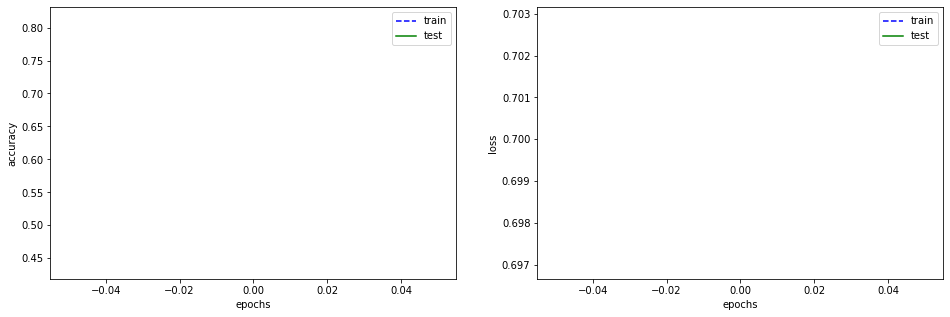

test tensor([0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928, 0.4928],
       device='cuda:0', dtype=torch.float64)


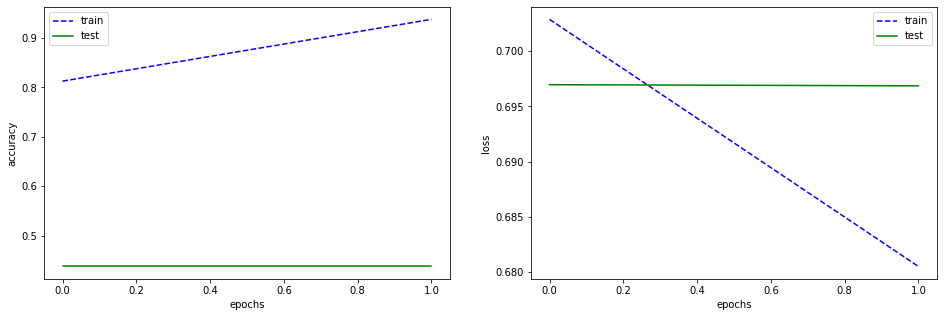

test tensor([0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930, 0.4930],
       device='cuda:0', dtype=torch.float64)


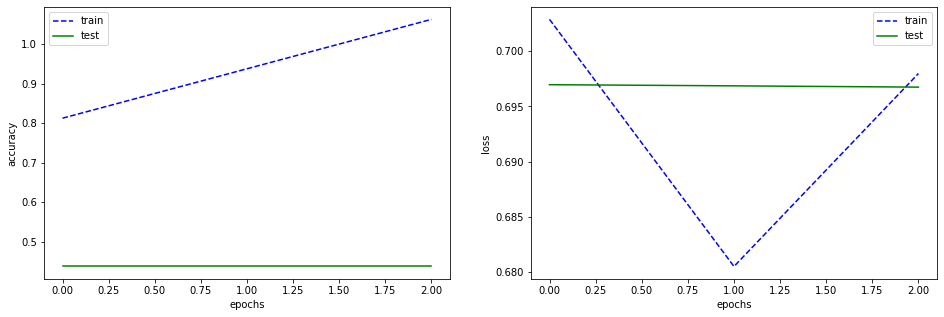

test tensor([0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932, 0.4932],
       device='cuda:0', dtype=torch.float64)


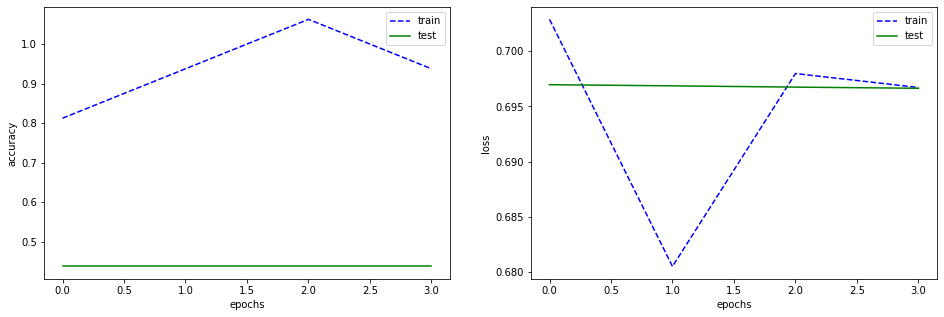

test tensor([0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934, 0.4934],
       device='cuda:0', dtype=torch.float64)


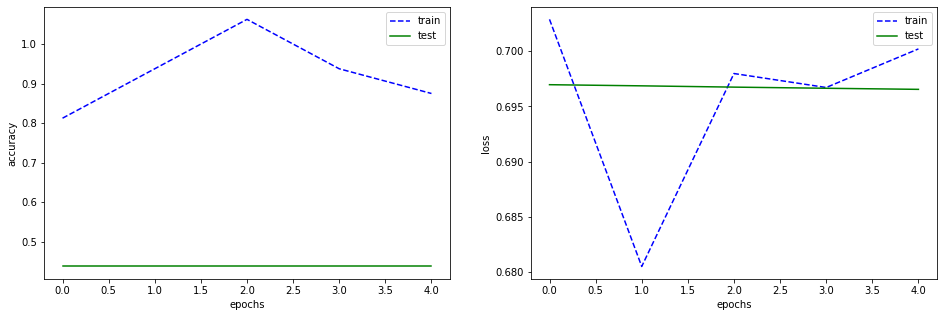

test tensor([0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936, 0.4936],
       device='cuda:0', dtype=torch.float64)


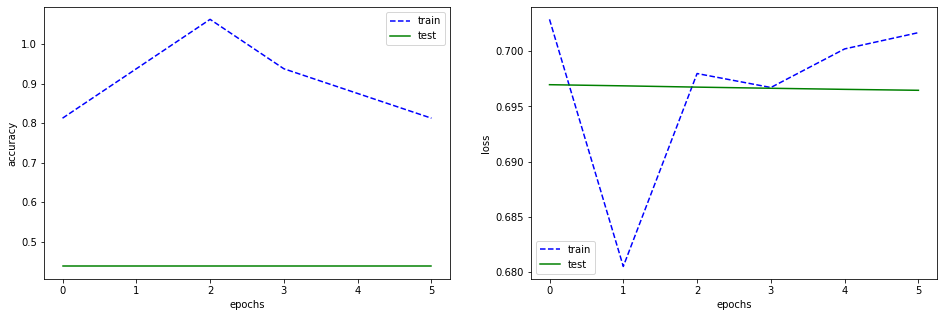

test tensor([0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937, 0.4937],
       device='cuda:0', dtype=torch.float64)


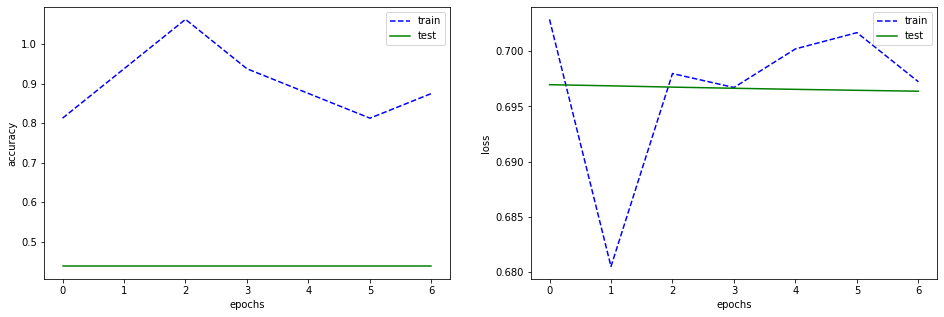

test tensor([0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939, 0.4939],
       device='cuda:0', dtype=torch.float64)


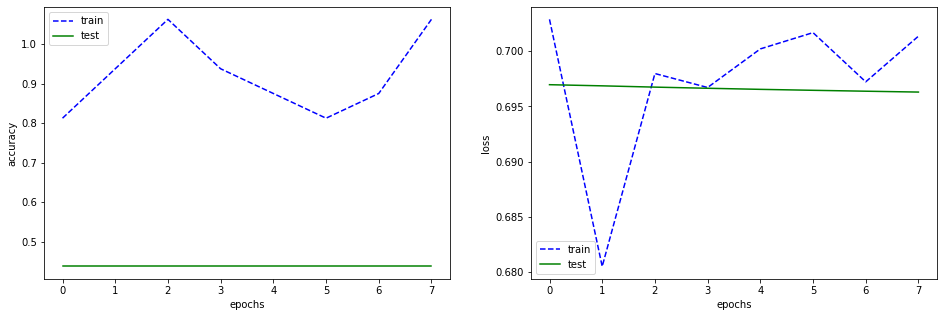

test tensor([0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940, 0.4940],
       device='cuda:0', dtype=torch.float64)


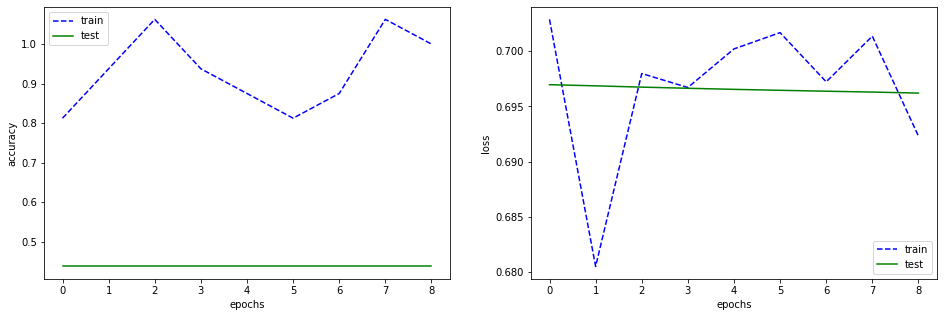

test tensor([0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943],
       device='cuda:0', dtype=torch.float64)
test tensor([0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943, 0.4943],
       device='cuda:0', dtype=torch.float64)


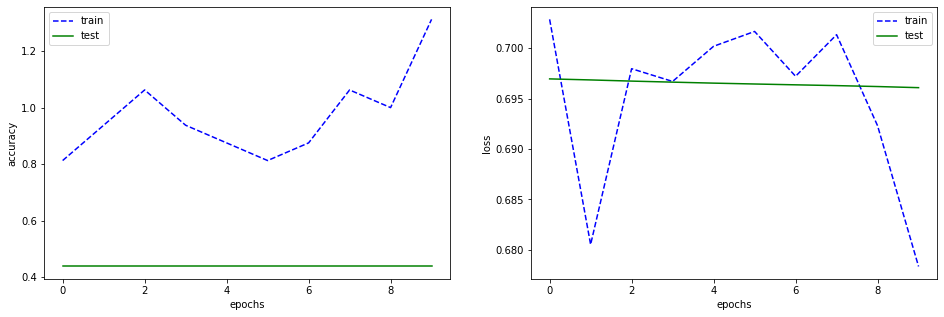

In [35]:
model = MyModel()
model.double()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_fn = nn.BCELoss()
LR = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

train(model=model, optimizer=optimizer, loss_fn=loss_fn, learning_rate=LR, n_epochs=10)